In [2]:
import numpy as np

Import Data

In [3]:
training_data = [] # Features per class
training_labels = [] # Labels
testing_data = [] # Features per class
testing_labels = [] # Labels
N = 5250 # Amount of data we want to use max: 5250

# Import the features
with open("traindata.txt", "r") as file:
    for line in file.readlines():
        features = [float(i) for i in line.split(",")]
        training_data.append(features)

with open("testdata.txt", "r") as file:
    for line in file.readlines():
        features = [float(i) for i in line.split(",")]
        testing_data.append(features)


# Import the labels
with open("trainlabels.txt", "r") as file:
    for line in file.readlines():
        label = float(line.rstrip())
        training_labels.append(label)

with open("targetlabels.txt", "r") as file:
    for line in file.readlines():
        label = float(line.rstrip())
        testing_labels.append(label)

# Convert data to numpy arrays
training_data = np.array(training_data)
training_labels = np.array(training_labels, dtype=np.int64)

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels, dtype=np.int64)

In [4]:
print("Training Data: ", training_data.shape, training_labels.shape)
print("Testing Data: ", testing_data.shape, testing_labels.shape)

Training Data:  (5250, 1041) (5250,)
Testing Data:  (2100, 1041) (2100,)


### Preprocess Data

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
def to_onehot(x):
    labels = np.unique(x)
    result = np.zeros(shape=(x.shape[0], labels.shape[0]))

    for i in range(len(x)):
        result[i][x[i]] = 1.0

    return result

def rotate_image(image, orientation):
    angle = 90 * orientation
    
    if angle == 0:
        return image
    elif angle == 90:
        return np.fliplr(np.transpose(image))  # Rotate 90 degrees clockwise
    elif angle == 180:
        return np.flipud(np.fliplr(image))  # Rotate 180 degrees
    elif angle == 270:
        return np.transpose(np.fliplr(image))  # Rotate 270 degrees clockwise

def preprocess_data(X):
    x = X[:-1]
    orientation = X[-1] # 4 orientations: 0, 1, 2, 3

    filtered_x = x[x >= 0] # Filter out negative values
    filtered_x = np.minimum(filtered_x, 255.0) # cap values greater than 255 to 255
    image = filtered_x.reshape([32, 32]) # reshape to an image

    normalized_image = MinMaxScaler().fit_transform(image) # Normalize Image

    rotated_image = rotate_image(normalized_image, orientation) #Rotate Image
    return rotated_image

In [7]:
preprocess_training_data = []
preprocess_testing_data = []

for X in training_data:
    preprocess_X = preprocess_data(X)
    preprocess_training_data.append(preprocess_X)

for X in testing_data:
    preprocess_X = preprocess_data(X)
    preprocess_testing_data.append(preprocess_X)

### Split Data

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
   
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Further splitting the training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size),
                                                      random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train = np.array(preprocess_training_data)
y_train = to_onehot(training_labels)
X_test, X_val, y_test, y_val = train_test_split(np.array(preprocess_testing_data), to_onehot(testing_labels), test_size=0.5, random_state=42)

#### Reshaping Data

In [10]:
new_shape = [-1, 1, 32, 32]
X_train = np.reshape(X_train, new_shape)
X_test = np.reshape(X_test, new_shape)
X_val = np.reshape(X_val, new_shape)

print(X_train.shape, X_test.shape, X_val.shape)

(5250, 1, 32, 32) (1050, 1, 32, 32) (1050, 1, 32, 32)


### Visualize Data

In [11]:
import matplotlib.pyplot as plt

In [12]:
def plot_images(image, title):
    plt.imshow(image.reshape([32, 32]), cmap="gray")
    plt.title(title)
    plt.show()

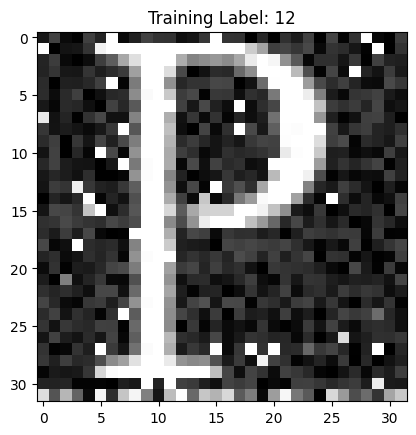

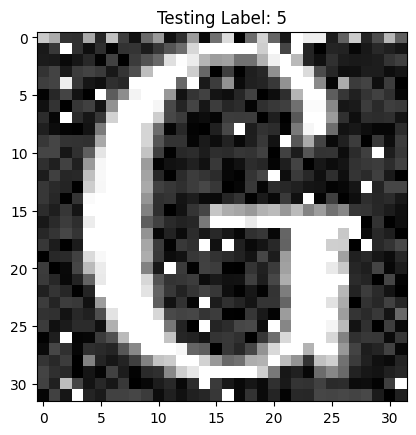

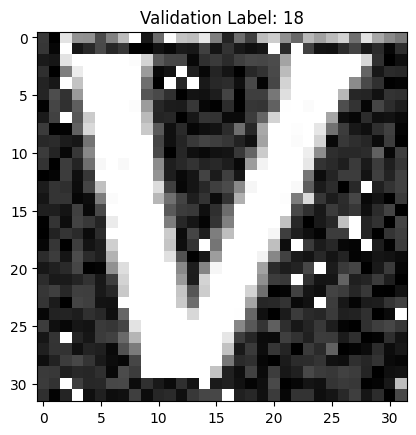

In [13]:
data_point = 14
plot_images(X_train[data_point], f"Training Label: {np.argmax(y_train[data_point])}")
plot_images(X_test[data_point], f"Testing Label: {np.argmax(y_test[data_point])}")
plot_images(X_val[data_point], f"Validation Label: {np.argmax(y_val[data_point])}")

Build Model

In [15]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, input_dims, n_outputs, p_dropout=0.20, save_dir="./models"):
        super(NeuralNetwork, self).__init__()
        self.save_dir = save_dir

        activation = nn.ReLU()
        dropout = nn.AlphaDropout(p=p_dropout)

        # Define layers with expected sizes
        self.network = nn.Sequential(
            nn.Conv2d(1, input_dims[0], kernel_size=3, padding=1),  # Input shape: (1, 32, 32)
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (32, 16, 16)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output shape: (64, 16, 16)
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (64, 8, 8)
            
            nn.Flatten(),
            nn.Linear(in_features=64 * 8 * 8, out_features=1024),
            activation,
            dropout,
            nn.Linear(in_features=1024, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=n_outputs),
        )

    def forward(self, X):
        logits = self.network(X)
        return logits

    def save(self, name):
        T.save(self.state_dict(), f"{self.save_dir}/{name}.pth")

    def load(self, name):
        self.load_state_dict(T.load(f"{self.save_dir}/{name}.pth"))


# Adjust dimensions for input and output
n_inputs = [32, 32]  # Width and height of the input image
n_outputs = 21  # Number of output classes

# Move a tensor to the GPU
device = T.device("cuda" if T.cuda.is_available() else "cpu")

# Initialize the model
model_1 = NeuralNetwork(input_dims=n_inputs, n_outputs=n_outputs, p_dropout=0.2).to(device)
model_2 = NeuralNetwork(input_dims=n_inputs, n_outputs=n_outputs, p_dropout=0.2).to(device)

dummy_image = T.rand(size=[1, 1, n_inputs[0], n_inputs[1]]).to(device)  # Dummy image tensor
pred_1 = model_1(dummy_image)
pred_2 = model_2(dummy_image)

print(pred_1, pred_2)


tensor([[ 0.2745,  0.1757, -0.3341,  0.2016,  0.3520,  0.1193, -0.4077, -0.0772,
          0.5217,  0.1718,  0.2405, -0.5337, -0.4470, -0.1269,  0.0753,  0.1894,
          0.5218, -0.2187, -0.1355, -0.1142, -0.4706]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([[ 4.0361e-01,  1.1678e-01,  3.3106e-01,  8.0045e-01,  2.5511e-01,
          5.8422e-01, -5.1442e-01, -8.8107e-02, -1.9522e-01,  1.5007e-01,
          1.6071e-01, -4.7726e-01, -1.3408e-01, -4.2231e-01, -7.9797e-02,
          4.8616e-01,  3.4761e-04, -1.7392e-02, -1.0809e-01,  2.0404e-01,
          2.9923e-01]], device='cuda:0', grad_fn=<AddmmBackward0>)


Train Model

In [16]:
def make_confusion_matrix(y_pred, y_true, labels):
    N = labels.shape[0]
    matrix = [[0] * (N + 1) for _ in range(N + 1)]

    matrix[0][0] = " "
    for i in range(1, N):
        matrix[i][0] = f"{i}"
        matrix[0][i] = f"{i}"

    for i in range(len(y_pred)):
        matrix[round(y_pred[i]) + 1][y_true[i] + 1] += 1

    for i in range(N):
        print(" ".join(map(str, matrix[i])))

    return sum([matrix[i + 1][i + 1] for i in range(2)]) / len(y_pred)


In [17]:
def validate_model(model1, model2, X_val, y_val, criterion):
    size = len(y_val)

    model1.eval()
    model2.eval()

    with T.no_grad():
        X = T.from_numpy(X_val).to(T.float32).to(device)
        y_true = T.Tensor(y_val).to(T.float).to(device)

        logits_1 = model1.forward(X)
        logits_2 = model2.forward(X)

        loss_1, loss_2 = criterion(logits_1, logits_2, y_true, 0.2)

        correct_1 = (logits_1.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
        correct_2 = (logits_2.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
        
        loss_1 /= size
        loss_2 /= size
        accuracy_1 = correct_1/size
        accuracy_2 = correct_2/size
        print(f"Validation Error (Model 1): \n Accuracy: {(100 * (accuracy_1)):>0.1f}%, Avg loss: {loss_1:>8f}")
        print(f"Validation Error (Model 2): \n Accuracy: {(100 * (accuracy_2)):>0.1f}%, Avg loss: {loss_2:>8f} \n")
    
    return accuracy_1, accuracy_2, loss_1, loss_2

In [18]:
def train_model(model_1, model_2, X_train, y_train, criterion, optimizer_1, optimizer_2):
    size = len(X_train)
    batch_size = 141

    #Prevents model from memorizing the position of data
    indices = np.random.randint(0, size, size)

    model_1.train()
    model_2.train()

    for i in range(size//batch_size):
        start = batch_size * i
        end = start + batch_size

        X = T.from_numpy(X_train[indices[start:end]]).to(T.float32).to(device)
        y_true = T.Tensor(y_train[indices[start:end]]).to(T.float).to(device)

        logits_1 = model_1.forward(X)
        logits_2 = model_2.forward(X)

        loss_1, loss_2 = criterion(logits_1, logits_2, y_true, 0.2)

        # Gradiant Descent using Adam optimizer for best performance
        optimizer_1.zero_grad()
        loss_1.backward()
        optimizer_1.step()

        optimizer_2.zero_grad()
        loss_2.backward()
        optimizer_2.step()

        correct_1 = (logits_1.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
        correct_2 = (logits_2.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()

        accuracy_1 = correct_1/batch_size
        accuracy_2 = correct_2/batch_size

        if (i * batch_size) % 564 == 0:
            loss_1, loss_2, current = loss_1.item(), loss_2.item(), (i + 1) * batch_size
            print(f"Accuracy_1: {(100 * (accuracy_1)):>0.1f}%, Loss_1: {loss_1:>7f}, ", end="")
            print(f"Accuracy_2: {(100 * (accuracy_2)):>0.1f}% Loss_2: {loss_2:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
import torch as T
import torch.nn.functional as F

# Loss functions
def loss_coteaching(y_1, y_2, t, forget_rate):
    loss_1 = F.cross_entropy(y_1, t, reduce = False)
    ind_1_sorted = T.argsort(loss_1.data)
    loss_1_sorted = loss_1[ind_1_sorted]

    loss_2 = F.cross_entropy(y_2, t, reduce = False)
    ind_2_sorted = T.argsort(loss_2.data)
    loss_2_sorted = loss_2[ind_2_sorted]

    remember_rate = 1 - forget_rate
    num_remember = int(remember_rate * len(loss_1_sorted))


    ind_1_update=ind_1_sorted[:num_remember]
    ind_2_update=ind_2_sorted[:num_remember]
    # exchange
    loss_1_update = F.cross_entropy(y_1[ind_2_update], t[ind_2_update])
    loss_2_update = F.cross_entropy(y_2[ind_1_update], t[ind_1_update])

    return T.sum(loss_1_update)/num_remember, T.sum(loss_2_update)/num_remember



In [24]:
import torch.optim as optim

# Global Variables
epochs = 1000
learning_rate = 1e-4

# Load Pre-Trained Models
# model_1.load("Conv-NeuralNetwork-Image Dataset-1_acc-74.67_loss-0.000001")
# model_2.load("Conv-NeuralNetwork-Image Dataset-2_acc-75.43_loss-0.000000")

criterion = loss_coteaching # Co-teaching loss function
optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate)
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate)

best_accuracy = 0.80 # ???

for epoch in range(epochs):
    print(f"Epoch {epoch}\n-------------------------------")

    train_model(model_1, model_2, X_train, y_train, criterion, optimizer_1, optimizer_2)
    print('Finished training')
    
    accuracy_1, accuracy_2, loss_1, loss_2 = validate_model(model_1, model_2, X_val, y_val, criterion)

    if max(accuracy_1, accuracy_2) > best_accuracy:
        print(f"[+] Saving Model...")

        model_1.save(f"Conv-NeuralNetwork-Image Dataset-1_acc-{accuracy_1 * 100:.2f}_loss-{loss_1:>8f}")
        model_2.save(f"Conv-NeuralNetwork-Image Dataset-2_acc-{accuracy_2 * 100:.2f}_loss-{loss_2:>8f}")
        best_accuracy = max(accuracy_1, accuracy_2)

        print(f"[!] Models Saved.")

    epoch += 1


Epoch 0
-------------------------------
Accuracy_1: 87.2%, Loss_1: 0.000000, Accuracy_2: 87.2% Loss_2: 0.000005  [  141/ 5250]
Accuracy_1: 90.8%, Loss_1: 0.000000, Accuracy_2: 90.8% Loss_2: 0.000000  [  705/ 5250]
Accuracy_1: 93.6%, Loss_1: 0.000003, Accuracy_2: 92.2% Loss_2: 0.000126  [ 1269/ 5250]
Accuracy_1: 89.4%, Loss_1: 0.000000, Accuracy_2: 89.4% Loss_2: 0.000000  [ 1833/ 5250]
Accuracy_1: 85.8%, Loss_1: 0.000000, Accuracy_2: 86.5% Loss_2: 0.000009  [ 2397/ 5250]
Accuracy_1: 85.8%, Loss_1: 0.000000, Accuracy_2: 85.8% Loss_2: 0.000000  [ 2961/ 5250]
Accuracy_1: 85.1%, Loss_1: 0.000000, Accuracy_2: 85.1% Loss_2: 0.000017  [ 3525/ 5250]
Accuracy_1: 84.4%, Loss_1: 0.000000, Accuracy_2: 84.4% Loss_2: 0.000000  [ 4089/ 5250]
Accuracy_1: 86.5%, Loss_1: 0.000001, Accuracy_2: 86.5% Loss_2: 0.000003  [ 4653/ 5250]
Accuracy_1: 91.5%, Loss_1: 0.000000, Accuracy_2: 91.5% Loss_2: 0.000000  [ 5217/ 5250]
Finished training
Validation Error (Model 1): 
 Accuracy: 77.3%, Avg loss: 0.000001
Valida

Testing Model

In [25]:
criterion = loss_coteaching

def test_model(model_1, model_2, X_test, y_test, criterion):
    size = len(y_test)

    model_1.eval()
    model_2.eval()
    with T.no_grad():
        X = T.from_numpy(X_test).to(T.float32).to(device)
        y_true = T.Tensor(y_test).to(T.float).to(device)

        logits_1 = model_1.forward(X)
        logits_2 = model_2.forward(X)

        loss_1, loss_2 = criterion(logits_1, logits_2, y_true, 0.2)

        correct_1 = (logits_1.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
        correct_2 = (logits_2.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
        
        loss_1 /= size
        loss_2 /= size
        accuracy_1 = correct_1/size
        accuracy_2 = correct_2/size
        
        print(f"Test Error (Model 1): \n Accuracy: {(100 * (accuracy_1)):>0.1f}%, Avg loss: {loss_1:>8f}")
        print(f"Test Error (Model 2): \n Accuracy: {(100 * (accuracy_2)):>0.1f}%, Avg loss: {loss_2:>8f} \n")

In [29]:
model_1.load("Conv-NeuralNetwork-Image Dataset-1_acc-80.00_loss-0.000001")
model_2.load("Conv-NeuralNetwork-Image Dataset-2_acc-80.19_loss-0.000001")
test_model(model_1, model_2, X_test, y_test, criterion)

Test Error (Model 1): 
 Accuracy: 78.7%, Avg loss: 0.000001
Test Error (Model 2): 
 Accuracy: 78.2%, Avg loss: 0.000001 

